In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/UIT Education/CS231.M21.KHTN/

/content/drive/MyDrive/UIT Education/CS231.M21.KHTN


# 0. Import 1 số thư viện cần thiết

In [3]:
!pip install decord
!pip install git+https://github.com/okankop/vidaug
!git clone https://github.com/dmlc/gluon-cv.git
!pip install mxnet-cu101
!pip install gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/okankop/vidaug to /tmp/pip-req-build-f8cjduo5
  Running command git clone -q https://github.com/okankop/vidaug /tmp/pip-req-build-f8cjduo5
  Created wheel for vidaug: filename=vidaug-0.1-py3-none-any.whl size=13034 sha256=900ebc744942796bfd780b942826eb07bc9ef42cc94c9669c7cb27ba1019dc45
  Stored in directory: /tmp/pip-ephem-wheel-cache-6xi9lld_/wheels/9b/d4/8e/257b7d79ad86dbaae5deb117aac58db00c60e697bec84b7c54
Successfully built vidaug
fatal: destination path 'gluon-cv' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 18 kB/s 
  Attempting uninstall: graphviz
    F

In [6]:
import os
import pandas as pd
import cv2
import numpy as np

from decord import VideoReader
from decord import cpu, gpu

import vidaug.augmentors as va
import random

from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM, SimpleRNN, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import datetime as dt

# 1. Lưu dữ liệu thành 1 thư mục

In [ ]:
def makeVideo(frames, path):
    height, width = frames[0].shape[:2]
    size = (width,height)

    out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    
    for i in range(len(frames)):
        out.write((frames[i] * 255).astype(np.uint8))
    out.release()

In [ ]:
def load_video(path, resize=(256, 256)):
    vr = VideoReader(path, ctx=cpu(0))
    vr.seek(0)
    frames = []
    
    try:
        while True:
            frame = vr.next().asnumpy()
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    except:
        pass

    return np.array(frames) / 255.0

In [ ]:
# %mkdir merged

In [ ]:
# destination = 'merged'

# path = 'Database/Videov2/train'
# folders = os.listdir(path)

# l = sum([len(os.listdir(path + '/' + x)) for x in os.listdir(path)])
# id = 1

# for folder in folders:
#     files = os.listdir(path + '/' + folder)
#     for file in files:
#         print(f'{id}/{l}: {file}')
#         id += 1

#         frames = load_video(path + '/' + folder + '/' + file)
#         makeVideo(frames, destination + '/' + file)

In [ ]:
# destination = 'merged'

# path = 'Database/Videov2/validate'
# folders = os.listdir(path)

# l = sum([len(os.listdir(path + '/' + x)) for x in os.listdir(path)])
# id = 1

# for folder in folders:
#     files = os.listdir(path + '/' + folder)
#     for file in files:
#         print(f'{id}/{l}: {file}')
#         id += 1
        
#         frames = load_video(path + '/' + folder + '/' + file)
#         makeVideo(frames, destination + '/' + file)

In [ ]:
%mkdir test

mkdir: cannot create directory ‘test’: File exists


In [ ]:
# destination = 'test'

# path = 'Database/Videov2/test'
# folders = os.listdir(path)

# l = sum([len(os.listdir(path + '/' + x)) for x in os.listdir(path)])
# id = 1

# for folder in folders:
#     files = os.listdir(path + '/' + folder)
#     for file in files:
#         print(f'{id}/{l}: {file}')
#         id += 1
        
#         frames = load_video(path + '/' + folder + '/' + file)
#         makeVideo(frames, destination + '/' + file)

In [ ]:
## 2361 2362 3745 vid1_nxfkY76mk.mp4 vidNQcK4qPOqtg và vidoaN4lC7ib1M  bị lỗi  

In [ ]:
def loaddata(path, batch, k):
    files = os.listdir(path)
    files = files[batch * k: min(len(files),  (batch+1) * k)]
    X = []
    names = []
    
    for file in files:
        X.append(load_video(path + '/' + file))
        names.append(file)
    
    return np.array(X), names

#2. Augument data

In [ ]:
def loaddata(path, batch, k):
    files = os.listdir(path)
    files = files[batch * k: min(len(files),  (batch+1) * k)]
    X = []
    names = []
    
    for file in files:
        X.append(load_video(path + '/' + file))
        names.append(file)
    
    return np.array(X), names

In [ ]:
import imageio
from IPython.display import Image

def showGif(path):
    frames = load_video(path)
    imageio.mimsave('raw.gif', (frames[..., ::-1] * 255.0).astype(np.uint8))
    return Image(open('raw.gif','rb').read())

In [ ]:
sometimes = lambda aug: va.Sometimes(0.6, aug)

seq = va.Sequential([ 
    sometimes(va.RandomRotate(degrees=10)),
    sometimes(va.HorizontalFlip()),
    sometimes(va.Downsample(0.5)),
    sometimes(va.Upsample(1.5)),
    sometimes(va.RandomShear(0.25, 0.25))
])

In [ ]:
def augmentation(X_train):
    X_train_aug = []
    
    for idx in range(len(X_train)):
        vid = X_train[idx]
        video_aug = np.array(seq(vid))
        X_train_aug.append(video_aug)

    return np.array(X_train_aug)

In [ ]:
%mkdir augmented

In [ ]:
# import time
# import gc

# # Augment data them times lần

# times = 2
# path = 'merged'
# k = 5
# batches = len(os.listdir(path)) // k + 1

# for t in range(times):
#     print(f'-------------------------------- x{t+1} training data --------------------------------')
#     for batch in range(batches):
#         X, names = loaddata(path, batch, k)

#         X_aug = augmentation(X)

#         del X
#         gc.collect()

#         destination = 'augmented'
#         for i in range(len(X_aug)):
#             makeVideo(X_aug[i], destination + '/' + names[i][:-4] + 'aug' + str(time.time()) + '.avi')

#         del X_aug
#         gc.collect()

#         print(f"Batch: {batch+1}/{batches}")



In [ ]:
path = 'augmented'
files = os.listdir(path)
showGif(path + '/' + files[random.randint(0, len(files)-1)])

# 3. Mask Video

In [ ]:
# !pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
from segmentation_models.metrics import iou_score, f1_score, precision, recall
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()
unet = sm.Unet('resnet34', encoder_weights='imagenet')
unet.summary()

In [ ]:
# Mask 1 ảnh
def maskImg(frame):
    pred = unet.predict(frame.reshape(1, 256, 256, 3)).reshape(256, 256)
    pred = (pred * 255).astype(np.uint8)

    pred[pred < 1] = 0
    pred[pred != 0] = 1

    newFrame = frame.copy()
    newFrame[pred == 0] = 0

    return newFrame
#Mask 1 video
def maskVideo(path):
    frames = load_video(path)
    newFrames = list(map(maskImg, frames))
    
    return np.array(newFrames)

In [ ]:
%mkdir all

In [ ]:
# paths = ['merged', 'augmented']
# destination = 'all'
# l = sum([len(os.listdir(x)) for x in paths])
# id = 1
# for path in paths:
#     files = os.listdir(path)
#     for file in files:
#         print(f'{id}/{l}: {file}')
#         id += 1

#         frames = maskVideo(path + '/' + file)
#         makeVideo(frames, destination + '/' + file)

# 4. Dùng Slowfast để trích xuất đặc trưng 

In [ ]:
def IncreaseFrame(frames, NoFrame=64):
    newFrames = []

    if (len(frames) <= NoFrame):
        rate = NoFrame // len(frames)
        d = NoFrame % len(frames)

        for i, frame in enumerate(frames):
            for j in range(rate):
                newFrames.append(frame)
            if i < d:
                newFrames.append(frame)
    else:
        id_choice = []
        id = list(range(len(frames)))
        for i in range(NoFrame):
            random.shuffle(id)

            choice = id[random.randint(0, len(id)-1)]
            id.remove(choice)

            id_choice.append(choice)

        id_choice = sorted(id_choice)

        for i in id_choice:
            newFrames.append(frames[i])
            
    return np.array(newFrames)

In [ ]:
# paths = ['merged', 'augmented']
# l = sum([len(os.listdir(x)) for x in paths])
# i = 1

# for path in paths:
#     files = os.listdir(path)
#     for file in files:
#         print(f'{i}/{l}: {file}')
#         i += 1
        
#         newFrames = IncreaseFrame(load_video(path + '/' + file))
#         makeVideo(newFrames, path + '/' + file)

In [ ]:
# paths = ['test']
# l = sum([len(os.listdir(x)) for x in paths])
# i = 1

# for path in paths:
#     files = os.listdir(path)
#     for file in files:
#         print(f'{i}/{l}: {file}')
#         i += 1
        
#         newFrames = IncreaseFrame(load_video(path + '/' + file))
#         makeVideo(newFrames, path + '/' + file)

In [ ]:
len(os.listdir('Database/Videov2/train'))

10

In [ ]:
%mkdir labels

mkdir: cannot create directory ‘labels’: File exists


In [ ]:
len(os.listdir('merged'))

5234

In [ ]:
import os


f = open('labels/videov2.txt', 'w')
for file in os.listdir('merged'):
    f.write('merged/' + file + '\n')

f.close()

In [ ]:
# import os


# f = open('labels/video.txt', 'w')
# for file in os.listdir('merged'):
#     f.write('merged/' + file + '\n')

# for file in os.listdir('augmented'):
#     f.write('augmented/' + file + '\n')

# f.close()

In [ ]:
# f = open('labels/video_test.txt', 'w')
# for file in os.listdir('test'):
#     f.write('test/' + file + '\n')

# f.close()

In [ ]:
# !python gluon-cv/scripts/action-recognition/feat_extract.py --data-list labels/video.txt --model slowfast_4x16_resnet50_kinetics400 --slowfast --slow-temporal-stride 16 --fast-temporal-stride 2 --num-segments 10 --new-length 64 --save-dir ./features --gpu-id 0

In [ ]:
# !python gluon-cv/scripts/action-recognition/feat_extract.py --data-list labels/video.txt --model slowfast_4x16_resnet50_kinetics400 --slowfast --slow-temporal-stride 16 --fast-temporal-stride 2 --num-segments 10 --new-length 64 --save-dir ./features --gpu-id 0

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.11.0+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '
INFO:logger:Namespace(data_aug='v1', data_dir='', data_list='labels/video.txt', dtype='float32', fast_temporal_stride=2, gpu_id=0, hashtag='', input_size=224, log_interval=10, mode=None, model='slowfast_4x16_resnet50_kinetics400', need_root=False, new_height=256, new_length=64, new_step=1, new_width=340, num_classes=400, num_crop=1, num_segments=10, resume_params='', save_dir='./features', slow_temporal_stride=16, slowfast=True, ten_crop=False, three_crop=False, use_decord=True, use_pretrained=True, video_loader=True)
100% 134964/134964 [00:02<00:00, 56402.42KB/s]
INFO:logger:Pre-trained model is successfully loaded from the model zoo.
INFO:logger:Successfully

In [ ]:
# !python gluon-cv/scripts/action-recognition/feat_extract.py --data-list labels/video_test.txt --model slowfast_4x16_resnet50_kinetics400 --slowfast --slow-temporal-stride 16 --fast-temporal-stride 2 --num-segments 10 --new-length 64 --save-dir ./features_test --gpu-id 0

#5. Loading train data

In [ ]:
%mkdir train_np
%mkdir train_npv2
%mkdir test_np

mkdir: cannot create directory ‘train_np’: File exists
mkdir: cannot create directory ‘test_np’: File exists


In [ ]:
import numpy as np
import pandas as pd

labelNames = {"bandaging": 0, "bowling": 1, "breakdancing": 2, "ironing": 3, "kissing": 4, "riding scooter": 5, "side kick": 6, "tap dancing": 7, "texting": 8, "washing hair": 9}
features = []
labels = []

paths = ['features']
df_train = pd.read_csv('Database/csv data/train.csv')
df_validate = pd.read_csv('Database/csv data/validate.csv')


for path in paths:
    files = os.listdir(path)

    for file in files:
        id = file[38:45]
        for i in range(len(df_train)):
            if id in df_train['youtube_id'][i]:
                label = df_train['label'][i]
        for i in range(len(df_validate)):
            if id in df_validate['youtube_id'][i]:
                label = df_validate['label'][i]

        if 'aug' in file:
          continue
        arr = np.load(path + '/' + file)
        features.append(arr[0])
        labels.append(labelNames[label])

features = np.array(features)
labels = np.array(labels)

print(features.shape, labels.shape)
np.save('train_npv2/features.npy', features)
np.save('train_npv2/labels.npy', labels)

(5234, 2304) (5234,)


In [ ]:
import numpy as np
import pandas as pd

labelNames = {"bandaging": 0, "bowling": 1, "breakdancing": 2, "ironing": 3, "kissing": 4, "riding scooter": 5, "side kick": 6, "tap dancing": 7, "texting": 8, "washing hair": 9}
labelNo = [0]*10
features = []
labels = []

paths = ['features']
df_train = pd.read_csv('Database/csv data/train.csv')
df_validate = pd.read_csv('Database/csv data/validate.csv')


for path in paths:
    files = os.listdir(path)

    for file in files:
        if 'aug' in file:
            continue
        id = file[38:45]
        for i in range(len(df_train)):
            if id in df_train['youtube_id'][i]:
                label = df_train['label'][i]
        
        for i in range(len(df_validate)):
            if id in df_validate['youtube_id'][i]:
                label = df_validate['label'][i]

        if labelNo[labelNames[label]] >= 237:
            continue
        labelNo[labelNames[label]] +=1
        
        arr = np.load(path + '/' + file)
        features.append(arr[0])
        labels.append(labelNames[label])

features = np.array(features)
labels = np.array(labels)

print(features.shape, labels.shape)
np.save('train_npv3/features.npy', features)
np.save('train_npv3/labels.npy', labels)

(2370, 2304) (2370,)


In [ ]:
import numpy as np
import pandas as pd

labelNames = {"bandaging": 0, "bowling": 1, "breakdancing": 2, "ironing": 3, "kissing": 4, "riding scooter": 5, "side kick": 6, "tap dancing": 7, "texting": 8, "washing hair": 9}
features = []
labels = []
df = pd.read_csv('Database/csv data/test.csv')

paths = ['features_test']
for path in paths:
    files = os.listdir(path)

    for file in files:
        id = file[38:45]
        
        for i in range(len(df)):
            if id in df['youtube_id'][i]:
                label = df['label'][i]
        
        arr = np.load(path + '/' + file)
        features.append(arr[0])
        labels.append(labelNames[label])

features = np.array(features)
labels = np.array(labels)

print(features.shape, labels.shape)
np.save('test_np/features.npy', features)
np.save('test_np/labels.npy', labels)

(771, 2304) (771,)


In [ ]:
X_train = np.load('train_np/features.npy')
y_train = np.load('train_np/labels.npy')
X_test = np.load('test_np/features.npy')
y_test = np.load('test_np/labels.npy')
# X.shape

In [ ]:
X_train = np.load('train_npv2/features.npy')
y_train = np.load('train_npv2/labels.npy')
X_test = np.load('test_np/features.npy')
y_test = np.load('test_np/labels.npy')

In [10]:
X_train = np.load('train_npv3/features.npy')
y_train = np.load('train_npv3/labels.npy')
X_test = np.load('test_np/features.npy')
y_test = np.load('test_np/labels.npy')

In [ ]:
X_train.shape

(2370, 2304)

# 6. Tạo model và train

In [7]:
model = Sequential()
model.add(Dense(10, activation='softmax', input_shape = (None, 2304)))
model.summary()

model.compile(optimizer='adamax', 
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 10)          23050     
                                                                 
Total params: 23,050
Trainable params: 23,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min', restore_best_weights = True)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=64, callbacks=[early_stopping_callback])

Epoch 1/100
38/38 [==============================] - 1s 8ms/step - loss: 0.9881 - accuracy: 0.8388 - val_loss: 0.6409 - val_accuracy: 0.8911
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.9574 - val_loss: 0.4963 - val_accuracy: 0.8949
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 0.2874 - accuracy: 0.9629 - val_loss: 0.4362 - val_accuracy: 0.9014
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 0.2433 - accuracy: 0.9641 - val_loss: 0.3999 - val_accuracy: 0.9040
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9705 - val_loss: 0.3809 - val_accuracy: 0.9027
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9730 - val_loss: 0.3657 - val_accuracy: 0.9014
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1797 - accuracy: 0.9730 - val_loss: 0.3526 - val_accuracy: 0.9079
Epoch 8/100
3

In [ ]:
model.save('modelv3.h5')

In [8]:
model.load_weights('modelv3.h5')

# 7. Đánh giá model

In [11]:
# Evaluate the trained model.
model_evaluation_history = model.evaluate(X_test, y_test)

25/25 [==============================] - 2s 2ms/step - loss: 0.2878 - accuracy: 0.9209


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

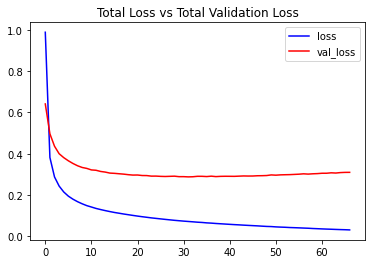

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

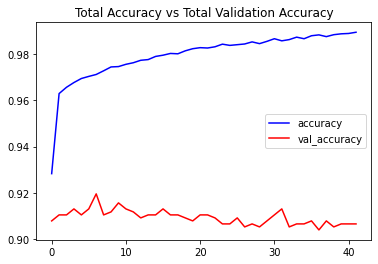

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Dự đoán trên tập test

In [12]:
y_pred = model.predict(X_test)

In [13]:
y_pred

array([[5.8075548e-05, 1.3184188e-04, 9.7827190e-01, ..., 2.0230860e-02,
        2.3916447e-05, 1.4404918e-04],
       [2.9846246e-03, 6.8226864e-04, 7.5174198e-03, ..., 6.1858336e-05,
        1.6964070e-04, 1.7119065e-04],
       [8.2846820e-02, 5.1980452e-03, 8.0253404e-01, ..., 2.4180597e-02,
        1.3405007e-02, 1.1256532e-02],
       ...,
       [2.4463562e-04, 6.7957392e-04, 2.2113819e-03, ..., 4.5909206e-03,
        4.1900710e-03, 2.4017349e-03],
       [1.9132604e-01, 2.0100113e-02, 2.1343675e-02, ..., 1.0342534e-01,
        2.5831183e-02, 8.0016918e-02],
       [6.4463489e-07, 3.1075922e-07, 7.5861942e-07, ..., 2.3276846e-06,
        3.5603127e-06, 2.1804133e-05]], dtype=float32)

In [14]:
y_pred = [i.argmax() for i in y_pred]

In [15]:
y_pred = np.array(y_pred)

In [16]:
y_pred

array([2, 6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 7, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 1, 2, 7, 7, 7, 7, 2, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 2,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 2,
       5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 7, 9, 9, 9,
       9, 9, 3, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [17]:
y_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [19]:
import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)

0.920881971465629

In [31]:
sklearn.metrics.precision_recall_fscore_support(y_test, y_pred, average=None)

(array([0.97435897, 0.95454545, 0.83333333, 0.92771084, 0.72413793,
        0.94382022, 0.91566265, 0.92682927, 0.93670886, 0.95714286]),
 array([0.91566265, 0.95454545, 0.91463415, 0.91666667, 0.84      ,
        0.97674419, 0.85393258, 0.92682927, 0.925     , 0.93055556]),
 array([0.94409938, 0.95454545, 0.87209302, 0.92215569, 0.77777778,
        0.96      , 0.88372093, 0.92682927, 0.93081761, 0.94366197]),
 array([83, 88, 82, 84, 25, 86, 89, 82, 80, 72]))

In [26]:
sklearn.metrics.f1_score(y_test, y_pred, average=None)

array([0.94409938, 0.95454545, 0.87209302, 0.92215569, 0.77777778,
       0.96      , 0.88372093, 0.92682927, 0.93081761, 0.94366197])

In [24]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[76,  0,  0,  2,  2,  0,  0,  0,  1,  2],
       [ 0, 84,  1,  1,  0,  2,  0,  0,  0,  0],
       [ 0,  0, 75,  0,  0,  1,  3,  2,  1,  0],
       [ 1,  2,  0, 77,  0,  1,  3,  0,  0,  0],
       [ 0,  0,  0,  1, 21,  0,  0,  1,  1,  1],
       [ 0,  0,  2,  0,  0, 84,  0,  0,  0,  0],
       [ 0,  1,  8,  0,  1,  0, 76,  2,  1,  0],
       [ 0,  1,  4,  0,  0,  0,  1, 76,  0,  0],
       [ 0,  0,  0,  1,  4,  1,  0,  0, 74,  0],
       [ 1,  0,  0,  1,  1,  0,  0,  1,  1, 67]])

In [ ]:
lst_diff = []
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        lst_diff.append(i)
lst_diff

[1,
 5,
 12,
 19,
 56,
 61,
 77,
 99,
 101,
 102,
 107,
 127,
 131,
 237,
 241,
 265,
 281,
 282,
 288,
 289,
 323,
 349,
 360,
 361,
 375,
 380,
 389,
 429,
 432,
 433,
 435,
 437,
 441,
 445,
 448,
 453,
 458,
 471,
 487,
 489,
 509,
 513,
 515,
 521,
 599,
 611,
 636,
 639,
 645,
 656,
 657,
 669,
 693,
 700,
 703,
 713,
 744,
 760,
 761,
 765,
 769]

In [ ]:
labelNames = {"bandaging": 0, "bowling": 1, "breakdancing": 2, "ironing": 3, "kissing": 4, "riding scooter": 5, "side kick": 6, "tap dancing": 7, "texting": 8, "washing hair": 9}
df = pd.read_csv('Database/csv data/test.csv')

cnt = 0
paths = ['features_test']
for path in paths:
    files = os.listdir(path)

    for file in files:
        id = file[38:45]
        
        for i in range(len(df)):
            if id in df['youtube_id'][i]:
                label = df['label'][i]
                id = df['youtube_id'][i]
        
        if cnt in lst_diff:
            print(id, label, list(labelNames.keys())[y_pred[cnt]])
        cnt += 1


-54-4pEYATY breakdancing side kick
1-Yd3Py976w breakdancing side kick
6adKBbLYH1g breakdancing texting
AeXXen-Ij-k breakdancing tap dancing
eTS0Xs9Jt0c breakdancing tap dancing
j4vm68cJtCc breakdancing riding scooter
x-tSlVP-GP8 breakdancing side kick
AlkRU43wrlU tap dancing breakdancing
C0DBMoI8ev4 tap dancing bowling
D-xdLFhZRak tap dancing breakdancing
GKC2tRvGw6Y tap dancing breakdancing
WMsO5d7nQfg tap dancing side kick
X4ktaUpQ_tE tap dancing breakdancing
i6_kTUtOuSc riding scooter breakdancing
r7qulk_teYY riding scooter breakdancing
HoUg88hd7vo washing hair kissing
TQYSgnfRu3U washing hair bandaging
TTqSu0zHFCg washing hair tap dancing
_BeX1Qyc1qU washing hair ironing
_SJhDbqg5lk washing hair texting
-BgEMSKNMXY ironing bowling
In8lHEGzmUA ironing side kick
Pexvw6Tp9w0 ironing side kick
Pm4AcSsS-Vc ironing bandaging
Z7thygQto0Y ironing riding scooter
dyHt4gj4zzg ironing bowling
l3JZN2yzQBI ironing side kick
EUl8RV2r6U4 side kick texting
FDMHYcF6Lfg side kick breakdancing
Iv7b0MR

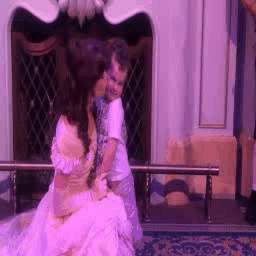

In [ ]:
showGif('test/vidrVg4gbCMfyA.mp4')